# Exercise 2: Detection of liver tumors

In this assignment, you will explore detection in medical images, specifically, detection of liver tumors . The data set consists of 201 contrast-enhanced CT images from patients with primary cancers and metastatic liver disease, as a
consequence of colorectal, breast, and lung primary cancers. The corresponding target ROIs were the segmentation of the liver and tumors inside the liver. This data set was selected due to the challenging nature of having significant
label unbalance between large (liver) and small (tumor) target region of interests (ROIs). The data was acquired in the IRCAD Hôpitaux Universitaires, Strasbourg, France and contained a subset of patients from the 2017 Liver Tumor
Segmentation (LiTS) challenge40.

Submit:

*  Notebook solutions (code)
*  Written explanations/ descriptions in PDF

In [ ]:
%pip install --quiet celluloid

In [ ]:
%pip install --quiet torchio

In [ ]:
%matplotlib inline
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import numpy as np
import cv2
import tarfile
import re

from celluloid import Camera
from IPython.display import HTML

import os
import random
import shutil

import torchio as tio
import torch

## Data Exploration

### Data Loading

Download dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
%cd /content/drive/MyDrive/AI_for_Healthcare/Exercise2/

Mounted at /content/drive
/content/drive/MyDrive/AI_for_Healthcare/Exercise2


We downloaded all of the data locally (into google drive), so we can access it from our notebook.

In [ ]:
root = Path("Task03_Liver/imagesTr/")
label = Path("Task03_Liver/labelsTr/")

### Data Inspection

In [ ]:
def img_path_to_label_path(path):
    """
    replace 'imagesTr' with 'labelsTr' in the path
    and get the subject id from 'imagesTr' for later use to find corresponding label in 'labelsTr'
    """
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    label_path = Path(*parts)

    # get subject id from filename
    number_match = re.search(r'liver_(\d+)\.nii\.gz', str(label_path))
    if number_match:
        number = int(number_match.group(1))
        return number, label_path
    else:
        return None, label_path

In [ ]:
file_paths = list(root.glob("liver*"))
sorted_paths = sorted(file_paths, key=lambda path: img_path_to_label_path(path)[0])

In [ ]:
# get data and label for specific subject

subject = 43
index = [img_path_to_label_path(path)[0] for path in sorted_paths].index(subject)
sample_path = sorted_paths[index]
label_path = img_path_to_label_path(sample_path)[1]

print(sample_path)
print(label_path)

Task03_Liver/imagesTr/liver_43.nii.gz
Task03_Liver/labelsTr/liver_43.nii.gz


In [ ]:
data = nib.load(sample_path)
label = nib.load(label_path)

ct = data.get_fdata()
mask = label.get_fdata().astype(int)

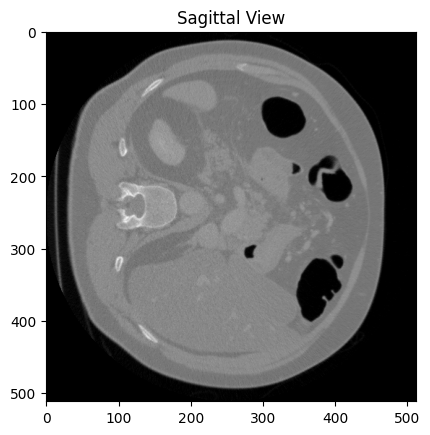

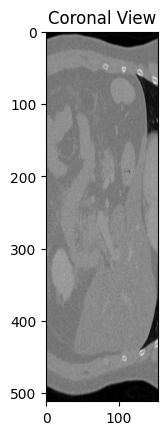

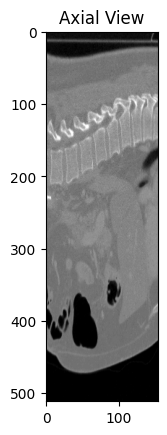

In [ ]:
# Sagittal view
sagittal_slice = ct[:, :, ct.shape[2] // 2]
plt.imshow(sagittal_slice, cmap='gray')
plt.title('Sagittal View')
plt.show()

# Coronal view
coronal_slice = ct[:, ct.shape[1] // 2, :]
plt.imshow(coronal_slice, cmap='gray')
plt.title('Coronal View')
plt.show()

# Axial view
axial_slice = ct[ct.shape[0] // 2, :, :]
plt.imshow(axial_slice, cmap='gray')
plt.title('Axial View')
plt.show()


The affine matrix represents the spatial transformation of the image data. It describes how the image is oriented, positioned, and scaled within the coordinate system.
Each axis code represents the primary direction of the corresponding axis in the image. The possible codes are:

'R' or 'L': Right or Left
'A' or 'P': Anterior or Posterior
'S' or 'I': Superior or Inferior

In [ ]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [ ]:
# dimension of the image/mask
x1, y1, z1 = ct.shape
x2, y2, z2 = mask.shape
print('CT dimension', x1, y1, z1)
print('Mask dimension',  x2, y2, z2)

CT dimension 512 512 155
Mask dimension 512 512 155


We can see that each slice is 512x512, and this sample has 155 slices.

Exploring the representation of our label data:

In [ ]:
slice_index = mask.shape[2] // 2
slice_mask = mask[:, :, slice_index]  # Extract the specific slice

# print the unique pixel values in the slice mask
unique_values = np.unique(slice_mask)
print("Unique pixel values:", unique_values)

# count the occurrence of each pixel value in the slice mask
value_counts = np.bincount(slice_mask.flatten())
print("Pixel value counts:", value_counts)


Unique pixel values: [0 1]
Pixel value counts: [241977  20167]


Looking at a sample slice for the scan and the mask at a given slice index:

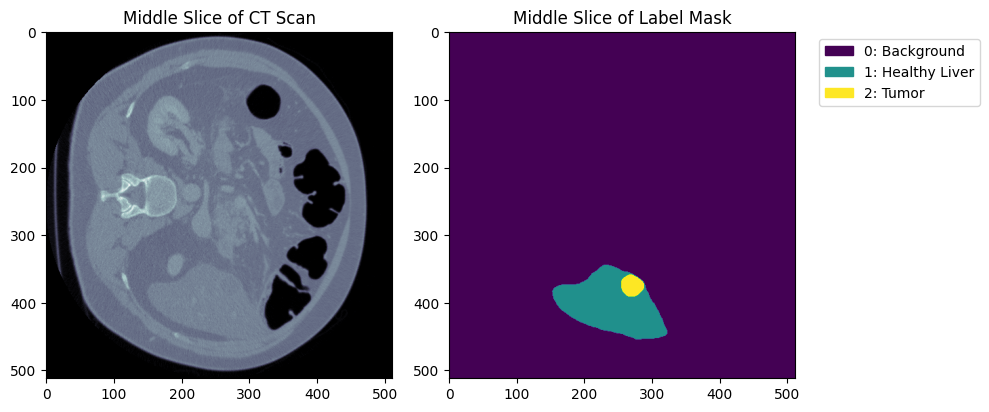

In [ ]:
def plot_single_slices(ct, mask, slice_index = ct.shape[2] // 2):
    """
    Plot a single slice from both the CT scan and the segmentation label.
    Default slice index is the middle slice, but can specify a different number.
    ct.shape[2] represents the size of the third dimension, which corresponds to the number of slices in the image along that dimension
    (should be the same for the image and the mask).

    """
    ct_data = ct[:, :, slice_index]

    mask_data = mask[:, :, slice_index]

    # plot image and label
    plt.clf()
    plt.close('all')

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    im1 = axs[0].imshow(ct_data, cmap='bone')
    axs[0].set_title('Middle Slice of CT Scan')
    im2 = axs[1].imshow(mask_data)
    axs[1].set_title('Middle Slice of Label Mask')

    unique_values = np.unique(mask_data)
    labels = ['Background', 'Healthy Liver', 'Tumor']
    legend_elements = [
        mpatches.Patch(color=im2.cmap(im2.norm(value)), label=f"{value}: {labels[value]}")
        for value in unique_values
    ]
    axs[1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')



    plt.tight_layout()
    plt.show()

plot_single_slices(ct, mask, 60)

Animate only the CT scan:

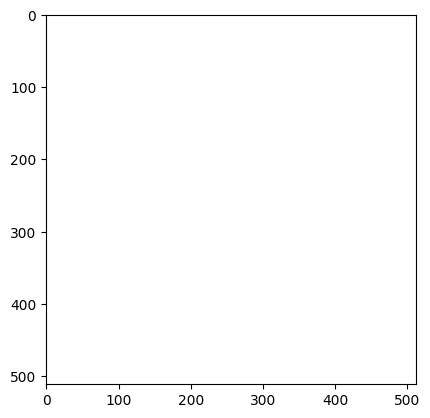

In [ ]:
plt.clf()
plt.close('all')
fig = plt.figure()
ct_camera = Camera(fig)
ct_animation = None

# animate CT
for i in range(ct.shape[2]):
    plt.imshow(ct[:, :, i], cmap="bone")
    ct_camera.snap()

ct_animation = ct_camera.animate()
HTML(ct_animation.to_html5_video())

Animate only the mask:

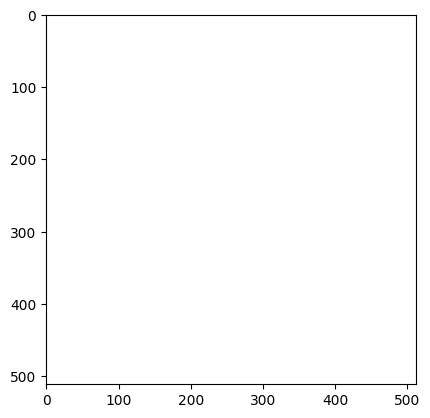

In [ ]:
plt.clf()
plt.close('all')
fig = plt.figure()
mask_camera = Camera(fig)
mask_animation = None

# animate mask
for i in range(mask.shape[2]):
    plt.imshow(mask[:,:,i])
    mask_camera.snap()

mask_animation = mask_camera.animate()

HTML(mask_animation.to_html5_video())
